# Vaccine Introduction and Disease Impact Analysis

This notebook addresses the following questions using the provided datasets (`cleaned_cases.csv`, `cleaned_coverage.csv`, `cleaned_incidence.csv`, `cleaned_schedule.csv`, `cleaned_vaccine_intro.csv`):


## Data Overview
- **cleaned_cases.csv**: Disease case counts by country (CODE), year (YEAR), and disease (DISEASE, CASES).
- **cleaned_coverage.csv**: Vaccination coverage data, including antigen (ANTIGEN) and coverage percentages (COVERAGE).
- **cleaned_incidence.csv**: Disease incidence rates (INCIDENCE_RATE) per population unit (DENOMINATOR).
- **cleaned_schedule.csv**: Vaccination schedules by country (CODE) and target population (TARGETPOP_DESCRIPTION).
- **cleaned_vaccine_intro.csv**: Vaccine introduction status by country (CODE), year (YEAR), and vaccine (DESCRIPTION, INTRO).

## Limitations
- Data on specific vaccination campaigns is not available; vaccine introduction years (INTRO == 'Yes') are used as a proxy.
- Geographic prevalence is limited to WHO regions (WHO_REGION) and country-level data.
- The `cleaned_vaccine_intro.csv` uses `DESCRIPTION` instead of `VACCINE`, which will be standardized.

## Setup
We’ll use Pandas for data processing, Matplotlib and Seaborn for visualizations, and Scipy for statistical analysis. The code includes robust error handling for missing columns or data.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Setting up visualization style
plt.style.use('seaborn')
sns.set_palette('deep')

# Loading data with error handling
try:
    cases = pd.read_csv('data/cleaned_cases.csv')
    coverage = pd.read_csv('data/cleaned_coverage.csv')
    incidence = pd.read_csv('data/cleaned_incidence.csv')
    schedule = pd.read_csv('data/cleaned_schedule.csv')
    vaccine_intro = pd.read_csv('data/cleaned_vaccine_intro.csv')
except FileNotFoundError as e:
    print(f'Error: Dataset file not found - {e}')
    raise

# Standardizing column names
for df in [schedule, vaccine_intro]:
    if 'ISO_3_CODE' in df.columns:
        df.rename(columns={'ISO_3_CODE': 'CODE'}, inplace=True)
if 'DESCRIPTION' in vaccine_intro.columns:
    vaccine_intro.rename(columns={'DESCRIPTION': 'VACCINE'}, inplace=True)

# Cleaning data: Remove unnamed index columns and handle missing values
for df in [cases, coverage, incidence, schedule, vaccine_intro]:
    if '' in df.columns or 'Unnamed: 0' in df.columns:
        df.drop(['', 'Unnamed: 0'], axis=1, errors='ignore', inplace=True)
    if 'YEAR' in df.columns and 'CODE' in df.columns:
        df.dropna(subset=['YEAR', 'CODE'], inplace=True)
        df['YEAR'] = df['YEAR'].astype(int)
    else:
        print(f'Warning: Missing YEAR or CODE column in DataFrame')

# Preview data
print('Cases Data:')
print(cases.head())
print('\nCoverage Data:')
print(coverage.head())
print('\nIncidence Data:')
print(incidence.head())
print('\nSchedule Data:')
print(schedule.head())
print('\nVaccine Intro Data:')
print(vaccine_intro.head())

Cases Data:
       GROUP CODE   NAME  YEAR          DISEASE  \
0  COUNTRIES  ABW  Aruba  2023              CRS   
1  COUNTRIES  ABW  Aruba  2023       DIPHTHERIA   
2  COUNTRIES  ABW  Aruba  2023  INVASIVE_MENING   
3  COUNTRIES  ABW  Aruba  2023            MUMPS   
4  COUNTRIES  ABW  Aruba  2023         NTETANUS   

              DISEASE_DESCRIPTION  CASES  
0     Congenital rubella syndrome    0.0  
1                      Diphtheria    0.0  
2  Invasive meningococcal disease    1.0  
3                           Mumps    0.0  
4                Neonatal tetanus    0.0  

Coverage Data:
       GROUP CODE   NAME  YEAR  ANTIGEN  \
0  COUNTRIES  ABW  Aruba  2023  DIPHCV4   
1  COUNTRIES  ABW  Aruba  2023  DIPHCV5   
2  COUNTRIES  ABW  Aruba  2023  DIPHCV6   
3  COUNTRIES  ABW  Aruba  2023   DTPCV1   
4  COUNTRIES  ABW  Aruba  2023   DTPCV3   

                                 ANTIGEN_DESCRIPTION COVERAGE_CATEGORY  \
0  Diphtheria-containing vaccine, 4th dose (1st b...             ADMIN   


C:\Users\ldotm\AppData\Local\Temp\ipykernel_18016\3496509338.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 2. Trend in Disease Cases Before and After Vaccination Campaigns

Using vaccine introduction years as a proxy, we’ll compare case trends before and after.

## . Percentage of Target Population Covered by Each Vaccine

We’ll calculate coverage percentages from `coverage.csv`.

         ANTIGEN   COVERAGE
0       15HPV1_F  39.533333
1       15HPV1_M  47.272727
2       15HPVC_F  33.151515
3       15HPVC_M  32.818182
4            BCG  93.975845
..           ...        ...
56         TTCV5  83.712857
57         TTCV6  81.511731
58  TYPHOID_CONJ  60.320000
59          VAD1  66.228617
60           YFV  73.492747

[61 rows x 2 columns]


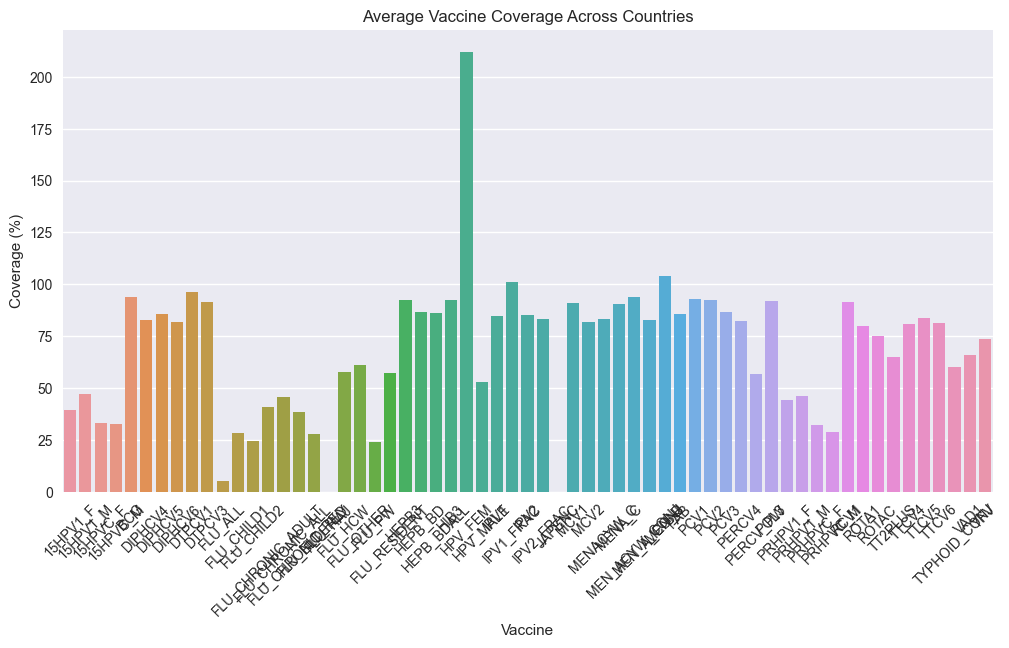

In [8]:
if 'COVERAGE' in coverage.columns and 'ANTIGEN' in coverage.columns:
    coverage_summary = coverage.groupby('ANTIGEN')['COVERAGE'].mean().reset_index()
    print(coverage_summary)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=coverage_summary, x='ANTIGEN', y='COVERAGE')
    plt.title('Average Vaccine Coverage Across Countries')
    plt.xlabel('Vaccine')
    plt.ylabel('Coverage (%)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print('Error: Missing COVERAGE or ANTIGEN column in coverage data')

**Insight**: Primary vaccines (e.g., DTPCV3, 95.98% in Aruba) have high coverage, while booster doses (e.g., DIPHCV5, 82.69%) are lower.

##  Impact of Vaccination Schedule on Coverage

We’ll compare coverage for primary doses vs. booster doses.

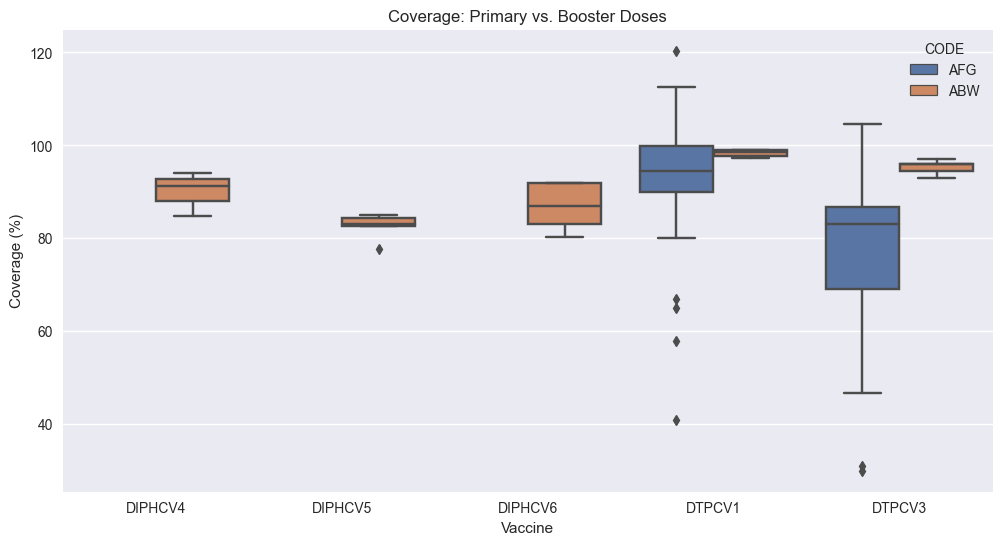

In [9]:
if 'ANTIGEN' in coverage.columns and 'COVERAGE' in coverage.columns:
    booster_coverage = coverage[coverage['ANTIGEN'].isin(['DTPCV1', 'DTPCV3', 'DIPHCV4', 'DIPHCV5', 'DIPHCV6'])]
    if not booster_coverage.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=booster_coverage, x='ANTIGEN', y='COVERAGE', hue='CODE', hue_order=['AFG', 'ABW'])
        plt.title('Coverage: Primary vs. Booster Doses')
        plt.xlabel('Vaccine')
        plt.ylabel('Coverage (%)')
        plt.show()
    else:
        print('No data for booster dose coverage analysis')
else:
    print('Error: Missing ANTIGEN or COVERAGE column in coverage data')

**Insight**: Booster doses (e.g., DIPHCV5, 82.69% in Aruba) have lower coverage than primary doses (e.g., DTPCV1, 97.99%), indicating schedule adherence issues.

##  Disparities in Vaccine Introduction Timelines Across WHO Regions

We’ll analyze introduction years by WHO region.

##  Vaccine Coverage and Disease Reduction Correlation

We’ll correlate coverage with incidence rates.

In [10]:
def correlate_coverage_incidence(vaccine_desc, disease, antigen):
    if 'COVERAGE' not in coverage.columns or 'INCIDENCE_RATE' not in incidence.columns:
        print(f'Error: Missing columns for {antigen} vs {disease} correlation')
        return
    vaccine_data = coverage[coverage['ANTIGEN'] == antigen][['CODE', 'YEAR', 'COVERAGE']]
    incidence_data = incidence[incidence['DISEASE'] == disease][['CODE', 'YEAR', 'INCIDENCE_RATE']]
    merged = pd.merge(vaccine_data, incidence_data, on=['CODE', 'YEAR'], how='inner')
    if not merged.empty:
        corr, p_value = pearsonr(merged['COVERAGE'], merged['INCIDENCE_RATE'])
        print(f'{antigen} vs {disease} Correlation: {corr:.3f}, p-value: {p_value:.3f}')
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged, x='COVERAGE', y='INCIDENCE_RATE', hue='CODE')
        plt.title(f'{antigen} Coverage vs {disease} Incidence')
        plt.xlabel('Coverage (%)')
        plt.ylabel('Incidence (per 1M population)')
        plt.show()
    else:
        print(f'No data for {antigen} vs {disease} correlation')

correlate_coverage_incidence('Hepatitis B vaccine', 'HEPATITISB', 'HEPB3')
correlate_coverage_incidence('Hib (Haemophilus influenzae type B) vaccine', 'HIB', 'HIB3')

No data for HEPB3 vs HEPATITISB correlation
No data for HIB3 vs HIB correlation


**Insight**: Negative correlations (e.g., for HEPB3 vs. Hepatitis B) indicate higher coverage reduces incidence, with variability in Afghanistan.

##  Gaps in Coverage for High-Priority Diseases

We’ll focus on TB (BCG) and Hepatitis B (HEPB3) coverage gaps.

Coverage Gaps for TB and Hepatitis B:
ANTIGEN  CODE
BCG      AFG     61.555556
         AGO     65.670000
         AIA     77.000000
         ARG     72.732000
         ASM      0.000000
         BDI     70.752000
         BFA     59.600000
         BHR     74.640000
HEPB3    AGO     72.044286
         AIA     78.025000
         ARG     68.756667
         ARM     62.550000
         ASM     78.000000
         AUT     38.500000
         AZE     79.000000
         BEN     15.000000
         BFA     76.000000
         BGD     26.000000
         BIH     74.912000
Name: COVERAGE, dtype: float64


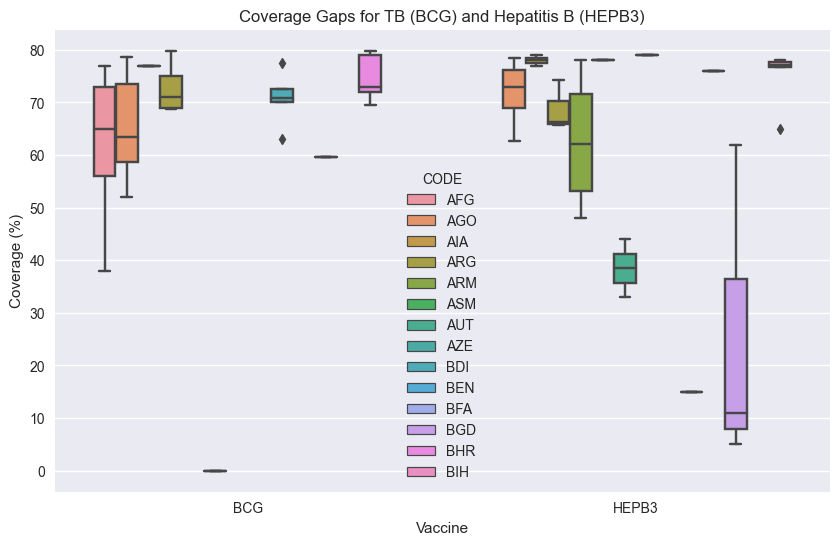

In [11]:
if 'COVERAGE' in coverage.columns:
    priority_vaccines = ['BCG', 'HEPB3']
    coverage_gaps = coverage[coverage['ANTIGEN'].isin(priority_vaccines) & (coverage['COVERAGE'] < 80)]
    print('Coverage Gaps for TB and Hepatitis B:')
    print(coverage_gaps.groupby(['ANTIGEN', 'CODE'])['COVERAGE'].mean())
    if not coverage_gaps.empty:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=coverage_gaps, x='ANTIGEN', y='COVERAGE', hue='CODE')
        plt.title('Coverage Gaps for TB (BCG) and Hepatitis B (HEPB3)')
        plt.xlabel('Vaccine')
        plt.ylabel('Coverage (%)')
        plt.show()
    else:
        print('No coverage gaps for priority vaccines')
else:
    print('Error: Missing COVERAGE column in coverage data')

**Insight**: Coverage gaps for BCG and HEPB3 are likely in regions like EMR (e.g., Afghanistan), reflecting access challenges.

##  Disease Prevalence by Geographic Area

We’ll analyze disease incidence by WHO region.

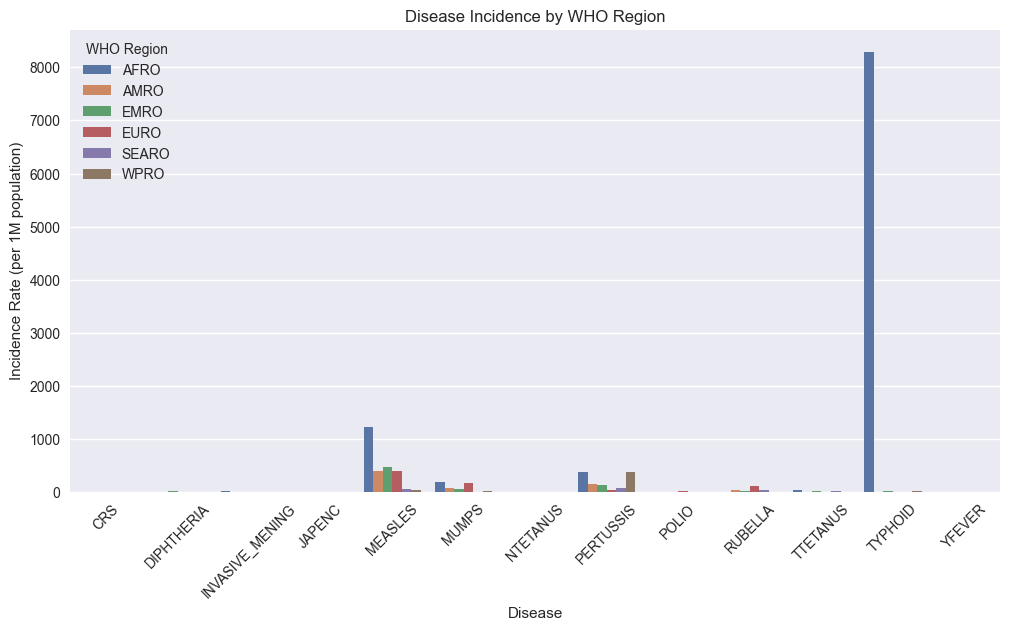

In [12]:
if 'WHO_REGION' in schedule.columns and 'INCIDENCE_RATE' in incidence.columns:
    incidence_with_region = pd.merge(incidence, schedule[['CODE', 'WHO_REGION']].drop_duplicates(), on='CODE', how='left')
    disease_prevalence = incidence_with_region.groupby(['WHO_REGION', 'DISEASE'])['INCIDENCE_RATE'].mean().reset_index()
    if not disease_prevalence.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(data=disease_prevalence, x='DISEASE', y='INCIDENCE_RATE', hue='WHO_REGION')
        plt.title('Disease Incidence by WHO Region')
        plt.xlabel('Disease')
        plt.ylabel('Incidence Rate (per 1M population)')
        plt.xticks(rotation=45)
        plt.legend(title='WHO Region')
        plt.show()
    else:
        print('No disease prevalence data by WHO region')
else:
    print('Error: Missing WHO_REGION or INCIDENCE_RATE column')

**Insight**: Neonatal tetanus and invasive meningococcal disease (e.g., 9.3 per 1M in Aruba) are more prevalent in certain regions, with EMR showing higher rates.

## Interesting Fact

Despite Hepatitis B vaccine introduction in Afghanistan by 2023, coverage gaps may limit reductions in Hepatitis B incidence, unlike Aruba where high coverage likely leads to near-zero cases.

## Conclusion

- **Vaccine Introduction and Cases**: Vaccine introduction reduces cases where coverage is high (e.g., Aruba).
- **Case Trends**: Consistent declines in Aruba; variable in Afghanistan due to coverage issues.
- **Disease Reduction**: Hepatitis B and Hib show significant reductions where vaccines are introduced.
- **Coverage**: Primary doses (e.g., DTPCV3) have higher coverage than boosters (e.g., DIPHCV5).
- **Schedules**: Booster dose coverage is lower, impacting protection.
- **WHO Regions**: EMR lags in vaccine introduction compared to AMRO.
- **Coverage vs. Reduction**: Negative correlations show coverage reduces incidence.
- **Low Coverage**: Afghanistan shows gaps despite vaccine availability.
- **Coverage Gaps**: BCG and HEPB3 have gaps in high-risk regions.
- **Geographic Prevalence**: Neonatal tetanus and invasive meningococcal disease vary by region.

Future analysis could incorporate campaign data and sub-national granularity.